<a href="https://colab.research.google.com/github/Iliasecc/Projets_Finance/blob/main/Projet_innovation1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pricing**

**avec monte carlo** **normale** **( blackschoolls )**

In [ ]:
import numpy as np
import pandas as pd

def load_and_prepare_data(file_path):
    data = pd.read_csv(file_path, skiprows=1)
    data.columns = ['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Change %']
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data['Price'] = pd.to_numeric(data['Price'], errors='coerce')
    data.dropna(subset=['Price'], inplace=True)
    return data

def calculate_volatility(data):
    data['Return'] = data['Price'].pct_change()
    return np.std(data['Return'].dropna()) * np.sqrt(252)  # Annualized volatility

def monte_carlo_option_pricing(S0, K, T, r, sigma, n_simulations=10000, n_steps=252):
    dt = T / n_steps  # Time step in years
    price_paths = np.zeros((n_simulations, n_steps + 1))
    price_paths[:, 0] = S0

    for t in range(1, n_steps + 1):
        z = np.random.standard_normal(n_simulations)
        price_paths[:, t] = price_paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

    # Afficher les premiers chemins de prix pour vérification
    print("Sample of price paths:")
    print(price_paths[:5, :5])  # Imprimer les 5 premières simulations et 5 premiers pas de temps

    payoff = np.maximum(price_paths[:, -1] - K, 0)

    # Vérifier les payoffs
    print("Sample of payoffs:")
    print(payoff[:10])  # Imprimer les 10 premiers payoffs

    return np.exp(-r * T) * np.mean(payoff)

file_path = '/content/Crude Oil WTI Futures Historical Data.csv'
K = 75  # Strike price
T = 1.0  # Time to maturity in years
r = 0.035  # Risk-free rate

# Run steps in sequence
historical_data = load_and_prepare_data(file_path)
print("Historical Data Loaded:")
print(historical_data.head())

sigma = calculate_volatility(historical_data)
print(f"Calculated Volatility: {sigma}")

S0 = historical_data['Price'].iloc[-1]
print(f"Current Price (S0): {S0}")

# Calculate option price
option_price = monte_carlo_option_pricing(S0, K, T, r, sigma)
print(f"European Call Option Price (Monte Carlo): {option_price:.2f}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/Crude Oil WTI Futures Historical Data.csv'

heston pricer


In [ ]:
import numpy as np

def initialize_heston_parameters(n_simulations, n_steps, V0=0.2, kappa=2.0, theta=0.2, sigma_vol=0.1):
    vol_paths = np.zeros((n_simulations, n_steps + 1))
    vol_paths[:, 0] = V0  # Set initial volatility
    return vol_paths, kappa, theta, sigma_vol


In [ ]:
import numpy as np

def simulate_stochastic_paths(S0, K, T, r, sigma, n_simulations, n_steps, vol_paths, kappa, theta, sigma_vol):
    dt = T / n_steps  # Time step
    price_paths = np.zeros((n_simulations, n_steps + 1))  # Initialize price paths
    price_paths[:, 0] = S0  # Set initial price

    # Generate two sets of random variables for simulating the stochastic processes
    for t in range(1, n_steps + 1):
        z1 = np.random.standard_normal(n_simulations)  # Random variable for price movement
        z2 = np.random.standard_normal(n_simulations)  # Random variable for volatility

        # Update volatility path using the Heston model
        vol_paths[:, t] = np.maximum(
            vol_paths[:, t - 1] + kappa * (theta - vol_paths[:, t - 1]) * dt  # Mean reversion to long-term average
            + sigma_vol * np.sqrt(vol_paths[:, t - 1] * dt) * z2,  # Random volatility fluctuations
            0  # Ensure volatility stays non-negative
        )

        # Update the price path using current volatility
        price_paths[:, t] = price_paths[:, t - 1] * np.exp(
            (r - 0.5 * vol_paths[:, t - 1]) * dt  # Drift component
            + np.sqrt(vol_paths[:, t - 1] * dt) * z1  # Volatility component
        )

    return price_paths, vol_paths


In [ ]:
def calculate_option_price_with_stochastic_volatility(price_paths, K, T, r):
    # Calcul du payoff de l'option européenne call avec volatilité stochastique
    payoff_stochastic = np.maximum(price_paths[:, -1] - K, 0)

    # Retourne le prix de l'option en actualisant le payoff avec le taux sans risque
    option_price = np.exp(-r * T) * np.mean(payoff_stochastic)

    return option_price


In [ ]:
S0 = 70  # Initial price
K = 75  # Strike price
T = 1.0  # Time to maturity
r = 0.035  # Risk-free rate
n_simulations = 10000
n_steps = 252

# Initialize Heston model parameters and volatility paths
vol_paths, kappa, theta, sigma_vol = initialize_heston_parameters(n_simulations, n_steps)

# Run simulation for price and volatility paths
price_paths, vol_paths = simulate_stochastic_paths(S0, K, T, r, sigma_vol, n_simulations, n_steps, vol_paths, kappa, theta, sigma_vol)

# Calculate option price with stochastic volatility
option_price_stochastic = calculate_option_price_with_stochastic_volatility(price_paths, K, T, r)

# Print the option price
print(f"European Call Option Price (Monte Carlo with Stochastic Volatility): {option_price_stochastic:.2f}")


European Call Option Price (Monte Carlo with Stochastic Volatility): 11.31


# **STOCK PRICE PREDICTION**


In [ ]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import plotly.figure_factory as ff
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [ ]:
df = pd.read_pickle('/content/ACC-15minute-Hist')
df = pd.DataFrame(df)
df['date'] = df['date'].apply(pd.to_datetime)
df.set_index('date',inplace=True)

In [ ]:
df.head()

,open,high,low,close,volume
date,,,,,
2015-02-02 09:15:00+05:30,1554.90,1556.70,1536.05,1541.85,15738
2015-02-02 09:30:00+05:30,1541.05,1549.90,1540.50,1542.35,13350
2015-02-02 09:45:00+05:30,1542.35,1549.20,1541.05,1546.30,8198
2015-02-02 10:00:00+05:30,1547.30,1549.95,1544.80,1545.25,6736
2015-02-02 10:15:00+05:30,1545.20,1548.00,1540.35,1541.60,2590


In [ ]:
new_df = pd.DataFrame()
new_df = df['close']
new_df.index = df.index

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_df.values

train_data=final_dataset[0:20000,]
valid_data=final_dataset[20000:,]

In [ ]:
train_df = pd.DataFrame()
valid_df = pd.DataFrame()
train_df['Close'] = train_data
train_df.index = new_df[0:20000].index
valid_df['Close'] = valid_data
valid_df.index = new_df[20000:].index

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset.reshape(-1,1))

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [ ]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_df[len(new_df)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

lstm_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19940/19940 - 497s - 25ms/step - loss: 3.0184e-04


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

In [ ]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


In [ ]:
valid_df['Predictions']=predicted_closing_price

In [ ]:
valid_df.head()

,Close,Predictions
date,,
2018-05-03 09:15:00+05:30,1557.60,1552.669800
2018-05-03 09:30:00+05:30,1557.00,1555.177368
2018-05-03 09:45:00+05:30,1560.20,1554.779053
2018-05-03 10:00:00+05:30,1556.05,1557.854492
2018-05-03 10:15:00+05:30,1555.85,1554.231567


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.index,y=train_df['Close'],
                    mode='lines',
                    name='Siemens Train Data'))
fig.add_trace(go.Scatter(x=valid_df.index,y=valid_df['Close'],
                    mode='lines',
                    name='Siemens Valid Data'))
fig.add_trace(go.Scatter(x=valid_df.index,y=valid_df['Predictions'],
                    mode='lines',
                    name='Prediction'))

In [ ]:
from sklearn.metrics import mean_squared_error
print('The Mean Squared Error is',mean_squared_error(valid_df['Close'].values,valid_df['Predictions'].values))

The Mean Squared Error is 36.0452489877286


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming 'valid_df' has the actual prices in 'Close' column and the predicted prices in 'Predictions' column
# Replace 'Close' with the actual column name that holds the true values for your validation data IF it's not 'Close'.

# Actual values (True prices) and Predicted values (from your model)
y_true = valid_df['Close'].values  # Changed 'True Price' to 'Close'
y_pred = valid_df['Predictions'].values

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Calculate the R-squared (R²) value
r2 = r2_score(y_true, y_pred)
print(f"R-squared (R²): {r2:.2f}")

Mean Absolute Error (MAE): 3.79
Mean Squared Error (MSE): 36.05
Root Mean Squared Error (RMSE): 6.00
R-squared (R²): 1.00


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=valid_df.index,y=valid_df['Close'],
                    mode='lines',
                    name='Test'))
fig.add_trace(go.Scatter(x=valid_df.index,y=valid_df['Predictions'],
                    mode='lines',
                    name='Predicted'))

#METHODE NORMALE

Nombre optimal d'options d'achat : 1
Nombre optimal d'options de vente : 7
Strikes des options optimales : [ 91.36616252 141.66706444 135.76713348 123.63638473  96.15871344
 148.913331   134.90477357 106.61004033 142.16770432 101.9533162
 142.67581838 147.61422014  87.28139938 106.50952906  81.08113489
  97.20256767 143.03096262  85.86289892 103.1924662  104.43289425
 101.37353824 146.53862025 131.38272693 116.10860065  96.05472631
 115.75324747  89.74742727 134.8708692   94.67033018 134.78922713]
Informations sur les options sélectionnées :
Type: call, Strike: 91.36616251826588, Échéance: 1 ans
Type: put, Strike: 141.6670644381818, Échéance: 1 ans
Type: put, Strike: 135.7671334820198, Échéance: 1 ans
Type: put, Strike: 123.63638472529206, Échéance: 1 ans
Type: put, Strike: 96.15871343828087, Échéance: 1 ans
Type: put, Strike: 148.91333099615105, Échéance: 1 ans
Type: put, Strike: 134.9047735707434, Échéance: 1 ans
Type: put, Strike: 106.61004033357514, Échéance: 1 ans


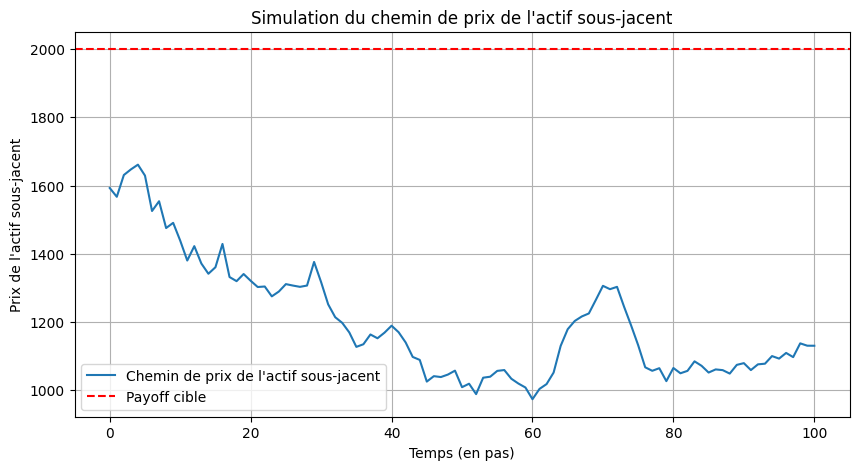

Valeur cible du payoff de l'option digitale : 2000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def black_scholes_delta_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def black_scholes_delta_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1) - 1

# Fonction de coût pour évaluer la performance du portefeuille avec calls et puts
def cost_function(n_calls, n_puts, S0, strikes, T, r, sigma, target_payoff, n_steps):
    dt = T / n_steps
    S_path = np.zeros(n_steps + 1)
    S_path[0] = S0

    for t in range(1, n_steps + 1):
        Z = np.random.normal()
        S_path[t] = S_path[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

    calls_weights = np.zeros((n_steps + 1, n_calls))
    puts_weights = np.zeros((n_steps + 1, n_puts))
    portfolio_value = np.zeros(n_steps + 1)

    for t in range(n_steps):
        T_remaining = T - (t * dt)
        call_prices = [black_scholes_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]
        put_prices = [black_scholes_put(S_path[t], K, T_remaining, r, sigma) for K in strikes[n_calls:n_calls + n_puts]]

        deltas_calls = [black_scholes_delta_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]
        deltas_puts = [black_scholes_delta_put(S_path[t], K, T_remaining, r, sigma) for K in strikes[n_calls:n_calls + n_puts]]

        current_portfolio_value = sum(calls_weights[t, i] * call_prices[i] for i in range(n_calls)) + \
                                  sum(puts_weights[t, j] * put_prices[j] for j in range(n_puts))

        needed_adjustment = target_payoff - current_portfolio_value

        # Ajuster les poids des calls
        for i in range(n_calls):
            calls_weights[t + 1, i] = calls_weights[t, i] + (needed_adjustment * dt) * deltas_calls[i]

        # Ajuster les poids des puts
        for j in range(n_puts):
            puts_weights[t + 1, j] = puts_weights[t, j] + (needed_adjustment * dt) * deltas_puts[j]

        portfolio_value[t + 1] = sum(calls_weights[t + 1, i] * call_prices[i] for i in range(n_calls)) + \
                                  sum(puts_weights[t + 1, j] * put_prices[j] for j in range(n_puts))

    return abs(portfolio_value[-1] - target_payoff), strikes  # Retourner l'écart absolu et les strikes

# Paramètres du modèle
S0 = valid_df['Predictions'].iloc[-1]  # Prix initial de l'actif sous-jacent
T = 1  # Temps à maturité
r = 0.05  # Taux d'intérêt sans risque
sigma = 0.3  # Volatilité
n_steps = 100  # Nombre de pas de temps

# Définir le marché des options
strikes = np.random.uniform(80, 150, 30)
options_market = {
    'calls': {K: black_scholes_call(S0, K, T, r, sigma) for K in strikes},
    'puts': {K: black_scholes_put(S0, K, T, r, sigma) for K in strikes}
}

# Valeur fixe de payoff de l'option digitale
target_payoff = 2000  # Valeur connue pour le payoff de l'option digitale

# Tester différentes combinaisons d'options vanilles
optimal_n_calls = None
optimal_n_puts = None
min_cost = float('inf')
optimal_strikes = None  # Pour stocker les strikes optimaux
selected_options_info = []  # Pour stocker les informations des options sélectionnées

# Tester toutes les combinaisons possibles de calls et puts
for n_calls in range(1, len(strikes) // 2 + 1):
    for n_puts in range(1, len(strikes) // 2 + 1):
        cost, strikes = cost_function(n_calls, n_puts, S0, strikes, T, r, sigma, target_payoff, n_steps)
        if cost < min_cost:
            min_cost = cost
            optimal_n_calls = n_calls
            optimal_n_puts = n_puts
            optimal_strikes = strikes  # Store the optimal strikes

# Collecter les informations des options optimales
for K in optimal_strikes[:optimal_n_calls]:
    selected_options_info.append({
        'type': 'call',
        'strike': K,
        'expiration': T
    })

for K in optimal_strikes[optimal_n_calls:optimal_n_calls + optimal_n_puts]:
    selected_options_info.append({
        'type': 'put',
        'strike': K,
        'expiration': T
    })

print(f"Nombre optimal d'options d'achat : {optimal_n_calls}")
print(f"Nombre optimal d'options de vente : {optimal_n_puts}")
print(f"Strikes des options optimales : {optimal_strikes}")
print("Informations sur les options sélectionnées :")
for option in selected_options_info:
    print(f"Type: {option['type']}, Strike: {option['strike']}, Échéance: {option['expiration']} ans")

# Visualisation avec le nombre optimal d'options
dt = T / n_steps
S_path = np.zeros(n_steps + 1)
S_path[0] = S0

# Simuler le chemin de prix de l'actif sous-jacent pour le nombre optimal d'options
for t in range(1, n_steps + 1):
    Z = np.random.normal()
    S_path[t] = S_path[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

calls_weights = np.zeros((n_steps + 1, optimal_n_calls))
puts_weights = np.zeros((n_steps + 1, optimal_n_puts))
portfolio_value = np.zeros(n_steps + 1)

for t in range(n_steps):
    T_remaining = T - (t * dt)
    call_prices = [black_scholes_call(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[:optimal_n_calls]]
    put_prices = [black_scholes_put(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[optimal_n_calls:optimal_n_calls + optimal_n_puts]]

    deltas_calls = [black_scholes_delta_call(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[:optimal_n_calls]]
    deltas_puts = [black_scholes_delta_put(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[optimal_n_calls:optimal_n_calls + optimal_n_puts]]

    current_portfolio_value = sum(calls_weights[t, i] * call_prices[i] for i in range(optimal_n_calls)) + \
                              sum(puts_weights[t, j] * put_prices[j] for j in range(optimal_n_puts))

    needed_adjustment = target_payoff - current_portfolio_value

    # Ajuster les poids des calls
    for i in range(optimal_n_calls):
        calls_weights[t + 1, i] = calls_weights[t, i] + (needed_adjustment * dt) * deltas_calls[i]

    # Ajuster les poids des puts
    for j in range(optimal_n_puts):
        puts_weights[t + 1, j] = puts_weights[t, j] + (needed_adjustment * dt) * deltas_puts[j]

    portfolio_value[t + 1] = sum(calls_weights[t + 1, i] * call_prices[i] for i in range(optimal_n_calls)) + \
                              sum(puts_weights[t + 1, j] * put_prices[j] for j in range(optimal_n_puts))

# Visualisation des résultats
plt.figure(figsize=(10, 5))
plt.plot(S_path, label='Chemin de prix de l\'actif sous-jacent')
plt.title('Simulation du chemin de prix de l\'actif sous-jacent')
plt.xlabel('Temps (en pas)')
plt.ylabel('Prix de l\'actif sous-jacent')
plt.axhline(y=target_payoff, color='r', linestyle='--', label='Payoff cible')
plt.legend()
plt.grid()
plt.show()

print(f"Valeur cible du payoff de l'option digitale : {target_payoff}")


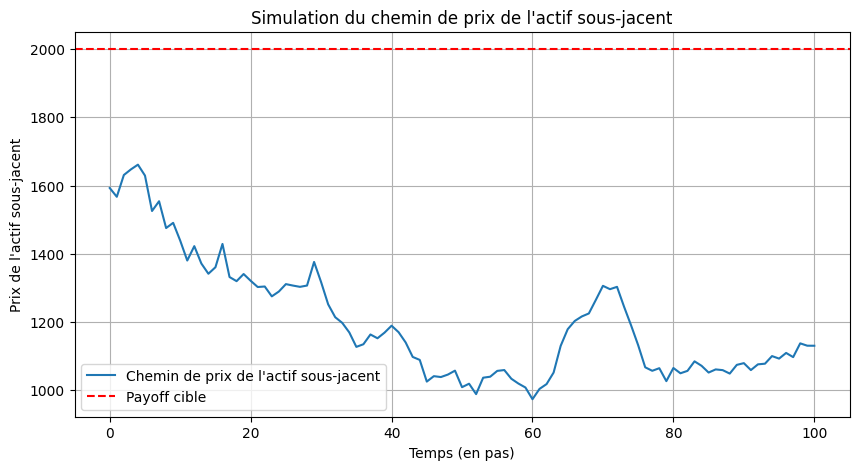

Valeur cible du payoff de l'option digitale : 2000
Payoff final du portefeuille de réplication : 1038.467879698155


In [ ]:
final_price = S_path[-1]  # Prix de l'actif sous-jacent à la fin de la simulation

# Calculer le payoff des options d'achat et de vente
payoff_calls = sum(max(0, final_price - K) for K in optimal_strikes[:optimal_n_calls])
payoff_puts = sum(max(0, K - final_price) for K in optimal_strikes[optimal_n_calls:optimal_n_calls + optimal_n_puts])

# Le payoff total du portefeuille de réplication
total_payoff = payoff_calls + payoff_puts

# Visualisation des résultats
plt.figure(figsize=(10, 5))
plt.plot(S_path, label='Chemin de prix de l\'actif sous-jacent')
plt.title('Simulation du chemin de prix de l\'actif sous-jacent')
plt.xlabel('Temps (en pas)')
plt.ylabel('Prix de l\'actif sous-jacent')
plt.axhline(y=target_payoff, color='r', linestyle='--', label='Payoff cible')
plt.legend()
plt.grid()
plt.show()

print(f"Valeur cible du payoff de l'option digitale : {target_payoff}")
print(f"Payoff final du portefeuille de réplication : {total_payoff}")

#REPLICATION DYNAMIQUE SANS INNOVATION



Nombre optimal d'options d'achat : 2
Strikes des options optimales : [1365.01210284 1736.81474991 1661.67346329 1392.07510058 1390.82829656
 1833.69670708 1277.82094622 1960.62049009 1990.36912575 1332.00180757
 1285.97653621 1202.19005204 1717.60000882 1647.78678653 1506.08449164
 1933.44222378 1629.53260323 1638.03577735 1651.88388695 1538.18686544]
Informations sur les options sélectionnées :
Type: call, Strike: 1365.0121028426174, Échéance: 1 ans
Type: call, Strike: 1736.8147499059885, Échéance: 1 ans


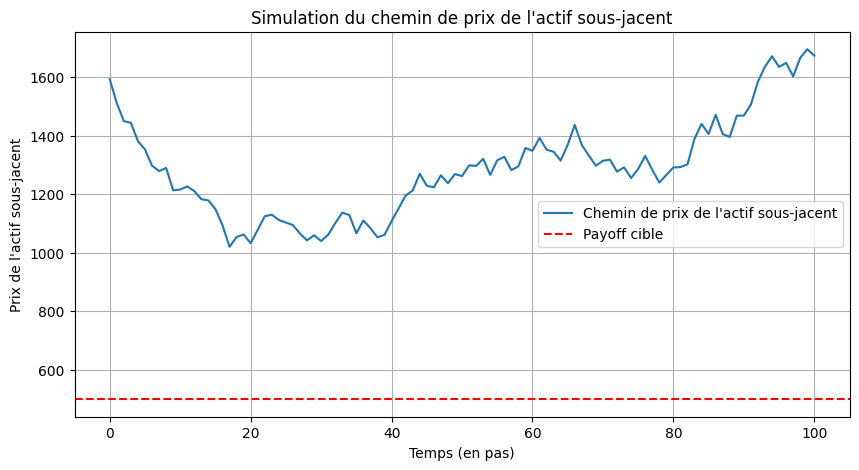

Valeur cible du payoff de l'option digitale : 500


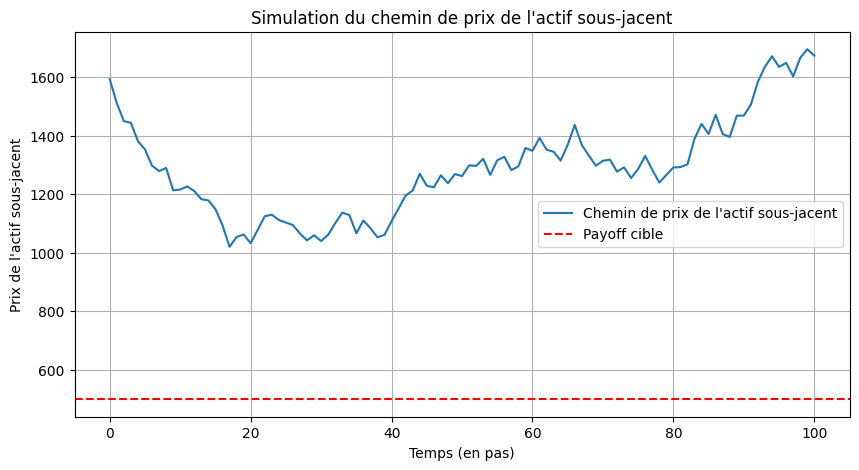

Valeur cible du payoff de l'option digitale : 500
Payoff final du portefeuille de réplication : 308.2168931915869


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_delta_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Fonction de coût pour évaluer la performance du portefeuille avec calls uniquement
def cost_function(n_calls, S0, strikes, T, r, sigma, target_payoff, n_steps):
    dt = T / n_steps
    S_path = np.zeros(n_steps + 1)
    S_path[0] = S0

    for t in range(1, n_steps + 1):
        Z = np.random.normal()
        S_path[t] = S_path[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

    calls_weights = np.zeros((n_steps + 1, n_calls))
    portfolio_value = np.zeros(n_steps + 1)

    for t in range(n_steps):
        T_remaining = T - (t * dt)
        call_prices = [black_scholes_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]
        deltas_calls = [black_scholes_delta_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]

        current_portfolio_value = sum(calls_weights[t, i] * call_prices[i] for i in range(n_calls))

        needed_adjustment = target_payoff - current_portfolio_value

        # Ajuster les poids des calls
        for i in range(n_calls):
            calls_weights[t + 1, i] = calls_weights[t, i] + (needed_adjustment * dt) * deltas_calls[i]

        portfolio_value[t + 1] = sum(calls_weights[t + 1, i] * call_prices[i] for i in range(n_calls))

    return abs(portfolio_value[-1] - target_payoff), strikes  # Retourner l'écart absolu et les strikes

# Paramètres du modèle
S0 = valid_df['Predictions'].iloc[-1]  # Prix initial de l'actif sous-jacent
T = 1  # Temps à maturité
r = 0.05  # Taux d'intérêt sans risque
sigma = 0.3  # Volatilité
n_steps = 100  # Nombre de pas de temps

# Définir le marché des options (seulement des calls)
strikes = np.random.uniform(1200, 2000, 20)
options_market = {
    'calls': {K: black_scholes_call(S0, K, T, r, sigma) for K in strikes}
}

# Valeur fixe de payoff de l'option digitale
target_payoff = 500  # Valeur connue pour le payoff de l'option digitale

# Tester différentes combinaisons d'options vanilles
optimal_n_calls = None
min_cost = float('inf')
optimal_strikes = None  # Pour stocker les strikes optimaux
selected_options_info = []  # Pour stocker les informations des options sélectionnées

# Tester toutes les combinaisons possibles de calls
for n_calls in range(1, len(strikes) + 1):
    cost, strikes = cost_function(n_calls, S0, strikes, T, r, sigma, target_payoff, n_steps)
    if cost < min_cost:
        min_cost = cost
        optimal_n_calls = n_calls
        optimal_strikes = strikes  # Store the optimal strikes

# Collecter les informations des options optimales
for K in optimal_strikes[:optimal_n_calls]:
    selected_options_info.append({
        'type': 'call',
        'strike': K,
        'expiration': T
    })

print(f"Nombre optimal d'options d'achat : {optimal_n_calls}")
print(f"Strikes des options optimales : {optimal_strikes}")
print("Informations sur les options sélectionnées :")
for option in selected_options_info:
    print(f"Type: {option['type']}, Strike: {option['strike']}, Échéance: {option['expiration']} ans")

# Visualisation avec le nombre optimal d'options
dt = T / n_steps
S_path = np.zeros(n_steps + 1)
S_path[0] = S0

# Simuler le chemin de prix de l'actif sous-jacent pour le nombre optimal d'options
for t in range(1, n_steps + 1):
    Z = np.random.normal()
    S_path[t] = S_path[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

calls_weights = np.zeros((n_steps + 1, optimal_n_calls))
portfolio_value = np.zeros(n_steps + 1)

for t in range(n_steps):
    T_remaining = T - (t * dt)
    call_prices = [black_scholes_call(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[:optimal_n_calls]]
    deltas_calls = [black_scholes_delta_call(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[:optimal_n_calls]]

    current_portfolio_value = sum(calls_weights[t, i] * call_prices[i] for i in range(optimal_n_calls))

    needed_adjustment = target_payoff - current_portfolio_value

    # Ajuster les poids des calls
    for i in range(optimal_n_calls):
        calls_weights[t + 1, i] = calls_weights[t, i] + (needed_adjustment * dt) * deltas_calls[i]

    portfolio_value[t + 1] = sum(calls_weights[t + 1, i] * call_prices[i] for i in range(optimal_n_calls))

# Visualisation des résultats
plt.figure(figsize=(10, 5))
plt.plot(S_path, label='Chemin de prix de l\'actif sous-jacent')
plt.title('Simulation du chemin de prix de l\'actif sous-jacent')
plt.xlabel('Temps (en pas)')
plt.ylabel('Prix de l\'actif sous-jacent')
plt.axhline(y=target_payoff, color='r', linestyle='--', label='Payoff cible')
plt.legend()
plt.grid()
plt.show()

print(f"Valeur cible du payoff de l'option digitale : {target_payoff}")
final_price = S_path[-1]  # Prix de l'actif sous-jacent à la fin de la simulation

# Calculer le payoff des options d'achat
payoff_calls = sum(max(0, final_price - K) for K in optimal_strikes[:optimal_n_calls])

# Le payoff total du portefeuille de réplication
total_payoff = payoff_calls

# Visualisation des résultats
plt.figure(figsize=(10, 5))
plt.plot(S_path, label='Chemin de prix de l\'actif sous-jacent')
plt.title('Simulation du chemin de prix de l\'actif sous-jacent')
plt.xlabel('Temps (en pas)')
plt.ylabel('Prix de l\'actif sous-jacent')
plt.axhline(y=target_payoff, color='r', linestyle='--', label='Payoff cible')
plt.legend()
plt.grid()
plt.show()

print(f"Valeur cible du payoff de l'option digitale : {target_payoff}")
print(f"Payoff final du portefeuille de réplication : {total_payoff}")


#simulation de montecarlo pour avoir des resultats moyen

Coût moyen du portefeuille : 398.59
Payoff moyen final du portefeuille : 492.52


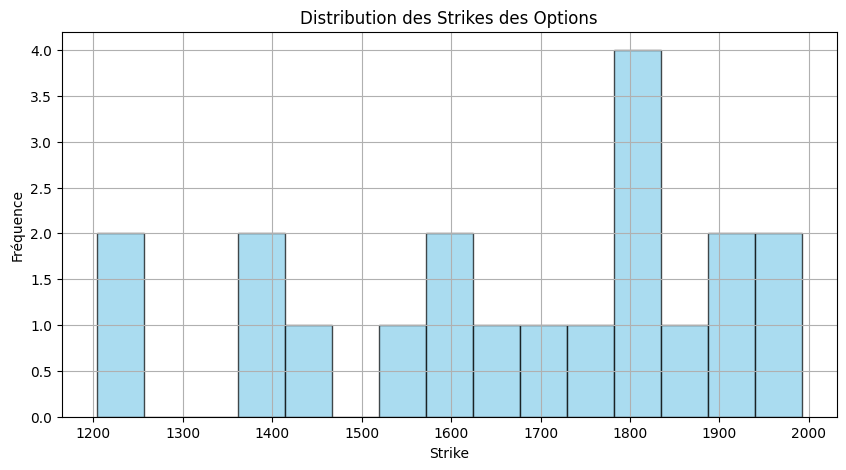

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Fonction de Black-Scholes pour le prix d'un call
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Delta du call dans le modèle de Black-Scholes
def black_scholes_delta_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Fonction de coût pour évaluer la performance du portefeuille
def cost_function(n_calls, S0, strikes, T, r, sigma, target_payoff, n_steps):
    dt = T / n_steps
    S_path = np.zeros(n_steps + 1)
    S_path[0] = S0

    for t in range(1, n_steps + 1):
        Z = np.random.normal()
        S_path[t] = S_path[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

    calls_weights = np.zeros((n_steps + 1, n_calls))
    portfolio_value = np.zeros(n_steps + 1)

    for t in range(n_steps):
        T_remaining = T - (t * dt)
        call_prices = [black_scholes_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]
        deltas_calls = [black_scholes_delta_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]

        current_portfolio_value = sum(calls_weights[t, i] * call_prices[i] for i in range(n_calls))
        needed_adjustment = target_payoff - current_portfolio_value

        for i in range(n_calls):
            calls_weights[t + 1, i] = calls_weights[t, i] + (needed_adjustment * dt) * deltas_calls[i]

        portfolio_value[t + 1] = sum(calls_weights[t + 1, i] * call_prices[i] for i in range(n_calls))

    return abs(portfolio_value[-1] - target_payoff), strikes

# Fonction de simulation de Monte Carlo
def monte_carlo_simulation(S0, strikes, T, r, sigma, target_payoff, n_steps, n_simulations):
    total_cost = 0
    total_payoff = 0

    for sim in range(n_simulations):
        optimal_n_calls = None
        min_cost = float('inf')
        optimal_strikes = None

        # Optimisation des options pour chaque simulation
        for n_calls in range(1, len(strikes) + 1):
            cost, strikes = cost_function(n_calls, S0, strikes, T, r, sigma, target_payoff, n_steps)
            if cost < min_cost:
                min_cost = cost
                optimal_n_calls = n_calls
                optimal_strikes = strikes

        # Simulation finale avec les options optimales
        dt = T / n_steps
        S_path = np.zeros(n_steps + 1)
        S_path[0] = S0
        for t in range(1, n_steps + 1):
            Z = np.random.normal()
            S_path[t] = S_path[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

        final_price = S_path[-1]
        payoff_calls = sum(max(0, final_price - K) for K in optimal_strikes[:optimal_n_calls])
        total_payoff += payoff_calls
        total_cost += min_cost

    # Moyennes des résultats
    average_cost = total_cost / n_simulations
    average_payoff = total_payoff / n_simulations

    return {
        "average_cost": average_cost,
        "average_payoff": average_payoff
    }

# Paramètres du modèle
S0 = 1500  # Prix initial de l'actif sous-jacent
T = 1  # Temps à maturité (1 an)
r = 0.05  # Taux d'intérêt sans risque
sigma = 0.3  # Volatilité
n_steps = 100  # Nombre de pas de temps
n_simulations = 50  # Nombre de simulations Monte Carlo
target_payoff = 500  # Payoff cible de l'option digitale
strikes = np.random.uniform(1200, 2000, 20)  # Strikes aléatoires pour le marché des options

# Lancer la simulation Monte Carlo
results = monte_carlo_simulation(S0, strikes, T, r, sigma, target_payoff, n_steps, n_simulations)

# Résultats
print(f"Coût moyen du portefeuille : {results['average_cost']:.2f}")
print(f"Payoff moyen final du portefeuille : {results['average_payoff']:.2f}")

# Visualisation des résultats
plt.figure(figsize=(10, 5))
plt.hist(strikes, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution des Strikes des Options")
plt.xlabel("Strike")
plt.ylabel("Fréquence")
plt.grid()
plt.show()


#UTILISER CELA


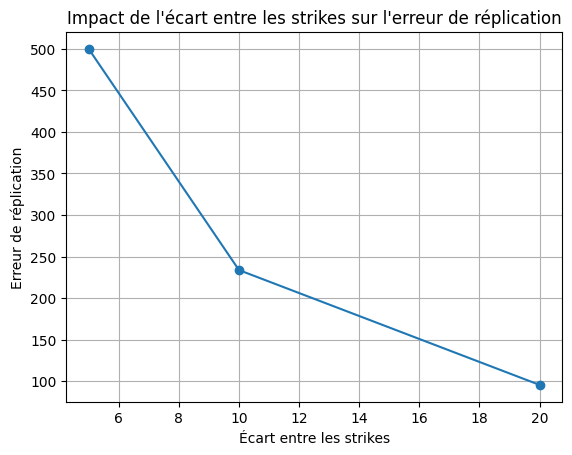

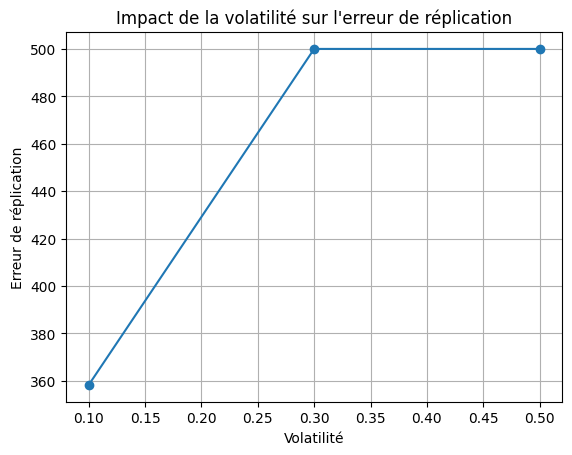

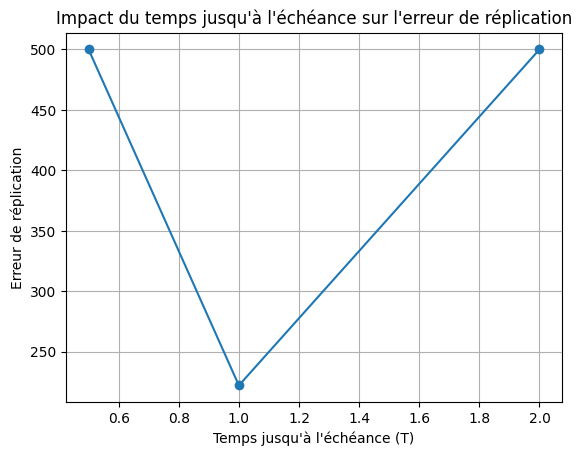

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Définir la fonction de Black-Scholes pour les options d'achat
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Calculer la sensibilité Delta pour les calls
def black_scholes_delta_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Fonction pour simuler le portefeuille de réplication
def replicate_portfolio(S0, strikes, T, r, sigma, target_payoff, n_steps, n_calls):
    dt = T / n_steps
    S_path = np.zeros(n_steps + 1)
    S_path[0] = S0
    calls_weights = np.zeros((n_steps + 1, n_calls))
    portfolio_value = np.zeros(n_steps + 1)

    for t in range(1, n_steps + 1):
        Z = np.random.normal()
        S_path[t] = S_path[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

    for t in range(n_steps):
        T_remaining = T - (t * dt)
        call_prices = [black_scholes_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]
        deltas_calls = [black_scholes_delta_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]
        current_portfolio_value = sum(calls_weights[t, i] * call_prices[i] for i in range(n_calls))
        needed_adjustment = target_payoff - current_portfolio_value

        for i in range(n_calls):
            calls_weights[t + 1, i] = calls_weights[t, i] + (needed_adjustment * dt) * deltas_calls[i]

        portfolio_value[t + 1] = sum(calls_weights[t + 1, i] * call_prices[i] for i in range(n_calls))

    return S_path, portfolio_value, calls_weights

# Calculer le payoff final du portefeuille et l'erreur de réplication
def calculate_replication_error(S_path, portfolio_value, target_payoff):
    final_price = S_path[-1]
    payoff_calls = sum(max(0, final_price - K) for K in optimal_strikes[:optimal_n_calls])
    total_payoff = payoff_calls
    error = abs(total_payoff - target_payoff)
    return error, total_payoff, payoff_calls

# Paramètres de simulation
S0 = valid_df['Predictions'].iloc[-1]  # Prix initial de l'actif sous-jacent
T = 1  # Temps à maturité
r = 0.05  # Taux d'intérêt sans risque
sigma = 0.3  # Volatilité
n_steps = 100  # Nombre de pas de temps
target_payoff = 500  # Payoff de l'option digitale

# Tester l'erreur de réplication avec différentes valeurs d'écart entre les strikes, de volatilité et de temps jusqu'à l'échéance
errors = []
for strike_diff in [5, 10, 20]:  # Différence entre les strikes
    strikes = np.arange(80, 150, strike_diff)
    n_calls = len(strikes)
    S_path, portfolio_value, calls_weights = replicate_portfolio(S0, strikes, T, r, sigma, target_payoff, n_steps, n_calls)
    error, total_payoff, payoff_calls = calculate_replication_error(S_path, portfolio_value, target_payoff)
    errors.append((strike_diff, error, total_payoff, payoff_calls))

# Visualiser l'impact de l'écart entre les strikes
strike_diffs, errors_vals, total_payoffs, payoff_calls = zip(*errors)
plt.plot(strike_diffs, errors_vals, label="Erreur de réplication", marker='o')
plt.xlabel('Écart entre les strikes')
plt.ylabel('Erreur de réplication')
plt.title("Impact de l'écart entre les strikes sur l'erreur de réplication")
plt.grid(True)
plt.show()

# Analyser l'erreur de réplication pour différentes volatilités
volatilities = [0.1, 0.3, 0.5]
errors_volatility = []
for vol in volatilities:
    strikes = np.arange(1200, 2000, 20)
    n_calls = len(strikes)
    S_path, portfolio_value, calls_weights = replicate_portfolio(S0, strikes, T, r, vol, target_payoff, n_steps, n_calls)
    error, total_payoff, payoff_calls = calculate_replication_error(S_path, portfolio_value, target_payoff)
    errors_volatility.append((vol, error))

# Visualiser l'impact de la volatilité sur l'erreur de réplication
vol_values, volatility_errors = zip(*errors_volatility)
plt.plot(vol_values, volatility_errors, label="Erreur de réplication", marker='o')
plt.xlabel('Volatilité')
plt.ylabel('Erreur de réplication')
plt.title("Impact de la volatilité sur l'erreur de réplication")
plt.grid(True)
plt.show()

# Analyser l'erreur de réplication pour différents temps jusqu'à l'échéance
times_to_maturity = [0.5, 1, 2]
errors_maturity = []
for T_maturity in times_to_maturity:
    strikes = np.arange(80, 150, 10)
    n_calls = len(strikes)
    S_path, portfolio_value, calls_weights = replicate_portfolio(S0, strikes, T_maturity, r, sigma, target_payoff, n_steps, n_calls)
    error, total_payoff, payoff_calls = calculate_replication_error(S_path, portfolio_value, target_payoff)
    errors_maturity.append((T_maturity, error))

# Visualiser l'impact du temps jusqu'à l'échéance sur l'erreur de réplication
maturity_values, maturity_errors = zip(*errors_maturity)
plt.plot(maturity_values, maturity_errors, label="Erreur de réplication", marker='o')
plt.xlabel('Temps jusqu\'à l\'échéance (T)')
plt.ylabel('Erreur de réplication')
plt.title("Impact du temps jusqu'à l'échéance sur l'erreur de réplication")
plt.grid(True)
plt.show()


Nombre optimal d'options d'achat : 1
Strikes des options optimales : [ 90.1278404  112.99305227 128.02276682 116.52203709 147.8995138
 141.28632574 127.39600684 111.27544437  98.99738436  92.3387022
 137.15522415 148.70624203  99.30136006 126.64185715  95.46120795
 131.86327187 106.81998994 106.41560765  88.43352863 134.49877384
 126.95547705 147.85951171  94.80852794 110.8229548  120.28744924
 104.4363162  113.97474747 105.48807895 100.48994378 123.326413  ]
Informations sur les options sélectionnées :
Type: call, Strike: 90.12784040053276, Échéance: 1 ans


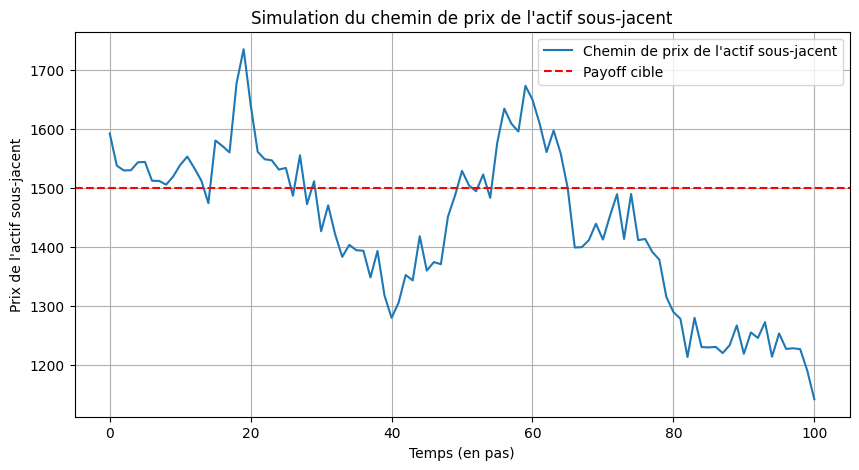

Valeur cible du payoff de l'option digitale : 1500


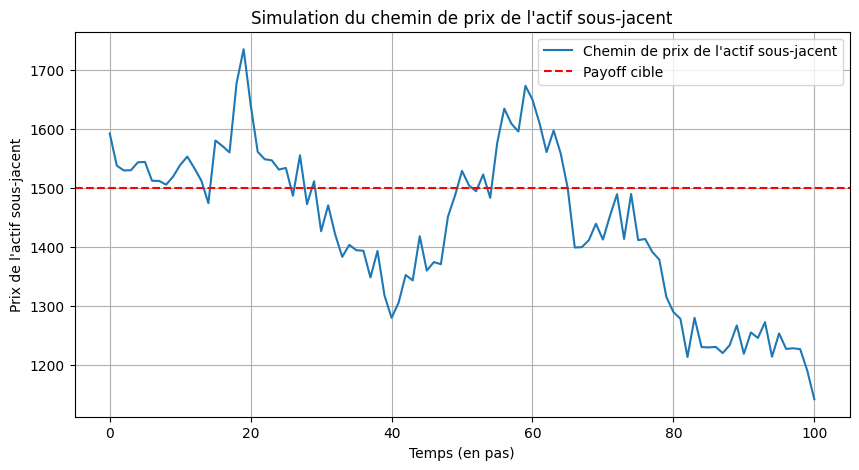

Valeur cible du payoff de l'option digitale : 1500
Payoff final du portefeuille de réplication : 1051.3473371712905


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_delta_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Fonction de coût pour évaluer la performance du portefeuille avec calls uniquement
def cost_function(n_calls, S0, strikes, T, r, sigma, target_payoff, n_steps):
    dt = T / n_steps
    S_path = np.zeros(n_steps + 1)
    S_path[0] = S0

    for t in range(1, n_steps + 1):
        Z = np.random.normal()
        S_path[t] = S_path[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

    calls_weights = np.zeros((n_steps + 1, n_calls))
    portfolio_value = np.zeros(n_steps + 1)

    for t in range(n_steps):
        T_remaining = T - (t * dt)
        call_prices = [black_scholes_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]
        deltas_calls = [black_scholes_delta_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]

        current_portfolio_value = sum(calls_weights[t, i] * call_prices[i] for i in range(n_calls))

        needed_adjustment = target_payoff - current_portfolio_value

        # Ajuster les poids des calls
        for i in range(n_calls):
            calls_weights[t + 1, i] = calls_weights[t, i] + (needed_adjustment * dt) * deltas_calls[i]

        portfolio_value[t + 1] = sum(calls_weights[t + 1, i] * call_prices[i] for i in range(n_calls))

    return abs(portfolio_value[-1] - target_payoff), strikes  # Retourner l'écart absolu et les strikes

# Paramètres du modèle
S0 = valid_df['Predictions'].iloc[-1]  # Prix initial de l'actif sous-jacent prédit par le modèle LSTM
T = 1  # Temps à maturité
r = 0.05  # Taux d'intérêt sans risque
sigma = 0.3  # Volatilité
n_steps = 100  # Nombre de pas de temps

# Définir le marché des options (seulement des calls)
strikes = np.random.uniform(80, 150, 30)
options_market = {
    'calls': {K: black_scholes_call(S0, K, T, r, sigma) for K in strikes}
}

# Valeur fixe de payoff de l'option digitale
target_payoff = 1500 # Valeur connue pour le payoff de l'option digitale

# Tester différentes combinaisons d'options vanilles
optimal_n_calls = None
min_cost = float('inf')
optimal_strikes = None  # Pour stocker les strikes optimaux
selected_options_info = []  # Pour stocker les informations des options sélectionnées

# Tester toutes les combinaisons possibles de calls
for n_calls in range(1, len(strikes) + 1):
    cost, strikes = cost_function(n_calls, S0, strikes, T, r, sigma, target_payoff, n_steps)
    if cost < min_cost:
        min_cost = cost
        optimal_n_calls = n_calls
        optimal_strikes = strikes  # Store the optimal strikes

# Collecter les informations des options optimales
for K in optimal_strikes[:optimal_n_calls]:
    selected_options_info.append({
        'type': 'call',
        'strike': K,
        'expiration': T
    })

print(f"Nombre optimal d'options d'achat : {optimal_n_calls}")
print(f"Strikes des options optimales : {optimal_strikes}")
print("Informations sur les options sélectionnées :")
for option in selected_options_info:
    print(f"Type: {option['type']}, Strike: {option['strike']}, Échéance: {option['expiration']} ans")

# Visualisation avec le nombre optimal d'options
dt = T / n_steps
S_path = np.zeros(n_steps + 1)
S_path[0] = S0

# Simuler le chemin de prix de l'actif sous-jacent pour le nombre optimal d'options
for t in range(1, n_steps + 1):
    Z = np.random.normal()
    S_path[t] = S_path[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

calls_weights = np.zeros((n_steps + 1, optimal_n_calls))
portfolio_value = np.zeros(n_steps + 1)

for t in range(n_steps):
    T_remaining = T - (t * dt)
    call_prices = [black_scholes_call(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[:optimal_n_calls]]
    deltas_calls = [black_scholes_delta_call(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[:optimal_n_calls]]

    current_portfolio_value = sum(calls_weights[t, i] * call_prices[i] for i in range(optimal_n_calls))

    needed_adjustment = target_payoff - current_portfolio_value

    # Ajuster les poids des calls
    for i in range(optimal_n_calls):
        calls_weights[t + 1, i] = calls_weights[t, i] + (needed_adjustment * dt) * deltas_calls[i]

    portfolio_value[t + 1] = sum(calls_weights[t + 1, i] * call_prices[i] for i in range(optimal_n_calls))

# Visualisation des résultats
plt.figure(figsize=(10, 5))
plt.plot(S_path, label='Chemin de prix de l\'actif sous-jacent')
plt.title('Simulation du chemin de prix de l\'actif sous-jacent')
plt.xlabel('Temps (en pas)')
plt.ylabel('Prix de l\'actif sous-jacent')
plt.axhline(y=target_payoff, color='r', linestyle='--', label='Payoff cible')
plt.legend()
plt.grid()
plt.show()

print(f"Valeur cible du payoff de l'option digitale : {target_payoff}")
final_price = S_path[-1]  # Prix de l'actif sous-jacent à la fin de la simulation

# Calculer le payoff des options d'achat
payoff_calls = sum(max(0, final_price - K) for K in optimal_strikes[:optimal_n_calls])

# Le payoff total du portefeuille de réplication
total_payoff = payoff_calls

# Visualisation des résultats
plt.figure(figsize=(10, 5))
plt.plot(S_path, label='Chemin de prix de l\'actif sous-jacent')
plt.title('Simulation du chemin de prix de l\'actif sous-jacent')
plt.xlabel('Temps (en pas)')
plt.ylabel('Prix de l\'actif sous-jacent')
plt.axhline(y=target_payoff, color='r', linestyle='--', label='Payoff cible')
plt.legend()
plt.grid()
plt.show()

print(f"Valeur cible du payoff de l'option digitale : {target_payoff}")
print(f"Payoff final du portefeuille de réplication : {total_payoff}")


#REPLICATION INNOVATRICE


Nombre optimal d'options d'achat : 1
Strikes des options optimaux : [1026.6548176]
Informations sur les options sélectionnées :
Type: call, Strike: 1026.6548176009492, Échéance: 1 ans


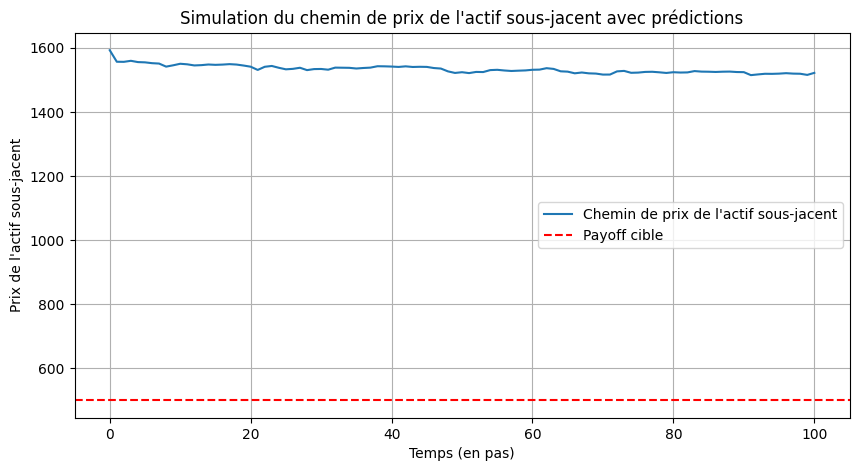

Valeur cible du payoff de l'option digitale : 500


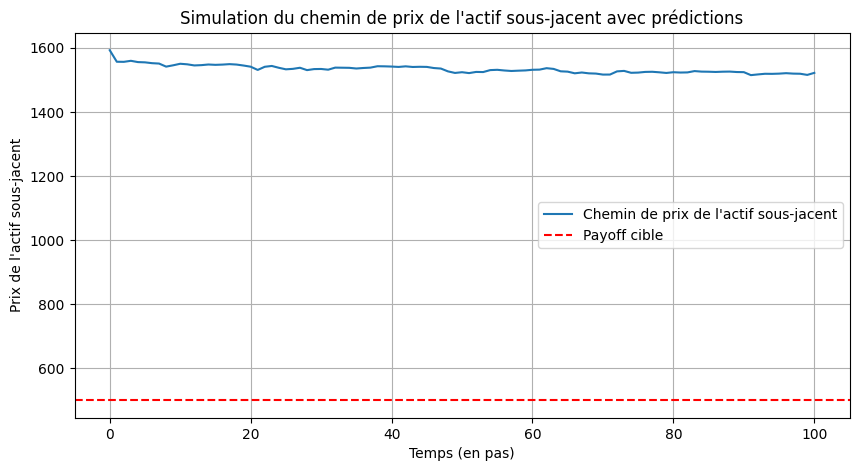

Valeur cible du payoff de l'option digitale : 500
Payoff final du portefeuille de réplication : 495.3179607193633


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_delta_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Fonction de coût pour évaluer la performance du portefeuille avec calls uniquement
def cost_function(n_calls, S0, strikes, T, r, sigma, target_payoff, n_steps, predictions):
    dt = T / n_steps
    S_path = np.zeros(n_steps + 1)
    S_path[0] = S0

    # Utiliser les prédictions de prix au lieu de simuler
    for t in range(1, n_steps + 1):
        S_path[t] = predictions[t]

    calls_weights = np.zeros((n_steps + 1, n_calls))
    portfolio_value = np.zeros(n_steps + 1)

    for t in range(n_steps):
        T_remaining = T - (t * dt)
        call_prices = [black_scholes_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]
        deltas_calls = [black_scholes_delta_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]

        current_portfolio_value = sum(calls_weights[t, i] * call_prices[i] for i in range(n_calls))

        needed_adjustment = target_payoff - current_portfolio_value

        # Ajuster les poids des calls
        for i in range(n_calls):
            calls_weights[t + 1, i] = calls_weights[t, i] + (needed_adjustment * dt) * deltas_calls[i]

        portfolio_value[t + 1] = sum(calls_weights[t + 1, i] * call_prices[i] for i in range(n_calls))

    return abs(portfolio_value[-1] - target_payoff), strikes  # Retourner l'écart absolu et les strikes

# Paramètres du modèle
S0 = valid_df['Predictions'].iloc[-1]  # Prix initial de l'actif sous-jacent prédit par le modèle LSTM
T = 1  # Temps à maturité
r = 0.05  # Taux d'intérêt sans risque
sigma = 0.3  # Volatilité
n_steps = 100  # Nombre de pas de temps

# Définir le marché des options (seulement des calls)
strikes = np.random.uniform(1000, 2000, 30)

# Utiliser les prédictions pour l'intégration dans le marché des options
predictions = valid_df['Predictions'].values  # Récupérer les prédictions du modèle LSTM

# Valeur fixe de payoff de l'option digitale
target_payoff = 500 # Valeur connue pour le payoff de l'option digitale

# Tester différentes combinaisons d'options vanilles
optimal_n_calls = None
min_cost = float('inf')
optimal_strikes = None  # Pour stocker les strikes optimaux
selected_options_info = []  # Pour stocker les informations des options sélectionnées

# Tester toutes les combinaisons possibles de calls
for n_calls in range(1, len(strikes) + 1):
    cost, strikes = cost_function(n_calls, S0, strikes, T, r, sigma, target_payoff, n_steps, predictions)
    if cost < min_cost:
        min_cost = cost
        optimal_n_calls = n_calls
        optimal_strikes = strikes  # Store the optimal strikes

# Résumé des résultats
optimal_strikes = strikes[:optimal_n_calls]
selected_options_info = [{'type': 'call', 'strike': K, 'expiration': T} for K in optimal_strikes]

print(f"Nombre optimal d'options d'achat : {optimal_n_calls}")
print(f"Strikes des options optimaux : {optimal_strikes}")
print("Informations sur les options sélectionnées :")
for option in selected_options_info:
    print(f"Type: {option['type']}, Strike: {option['strike']}, Échéance: {option['expiration']} ans")

# Visualisation avec le nombre optimal d'options
dt = T / n_steps
S_path = np.zeros(n_steps + 1)
S_path[0] = S0

# Utiliser les prédictions pour ajuster la simulation
for t in range(1, n_steps + 1):
    S_path[t] = predictions[t]

calls_weights = np.zeros((n_steps + 1, optimal_n_calls))
portfolio_value = np.zeros(n_steps + 1)

for t in range(n_steps):
    T_remaining = T - (t * dt)
    call_prices = [black_scholes_call(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[:optimal_n_calls]]
    deltas_calls = [black_scholes_delta_call(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[:optimal_n_calls]]

    current_portfolio_value = sum(calls_weights[t, i] * call_prices[i] for i in range(optimal_n_calls))

    needed_adjustment = target_payoff - current_portfolio_value



    portfolio_value[t + 1] = sum(calls_weights[t + 1, i] * call_prices[i] for i in range(optimal_n_calls))

# Visualisation des résultats
plt.figure(figsize=(10, 5))
plt.plot(S_path, label='Chemin de prix de l\'actif sous-jacent')
plt.title('Simulation du chemin de prix de l\'actif sous-jacent avec prédictions')
plt.xlabel('Temps (en pas)')
plt.ylabel('Prix de l\'actif sous-jacent')
plt.axhline(y=target_payoff, color='r', linestyle='--', label='Payoff cible')
plt.legend()
plt.grid()
plt.show()

print(f"Valeur cible du payoff de l'option digitale : {target_payoff}")
final_price = S_path[-1]  # Prix de l'actif sous-jacent à la fin de la simulation

# Calculer le payoff des options d'achat
payoff_calls = sum(max(0, final_price - K) for K in optimal_strikes[:optimal_n_calls])

# Le payoff total du portefeuille de réplication
total_payoff = payoff_calls

# Visualisation des résultats
plt.figure(figsize=(10, 5))
plt.plot(S_path, label='Chemin de prix de l\'actif sous-jacent')
plt.title('Simulation du chemin de prix de l\'actif sous-jacent avec prédictions')
plt.xlabel('Temps (en pas)')
plt.ylabel('Prix de l\'actif sous-jacent')
plt.axhline(y=target_payoff, color='r', linestyle='--', label='Payoff cible')
plt.legend()
plt.grid()
plt.show()

print(f"Valeur cible du payoff de l'option digitale : {target_payoff}")
print(f"Payoff final du portefeuille de réplication : {total_payoff}")


#ajout d'un terme prenant en compte le risque de variations

Nombre optimal d'options d'achat : 1
Strikes des options optimaux : [1171.27253543]
Informations sur les options sélectionnées :
Type: call, Strike: 1171.2725354312215, Échéance: 1 ans


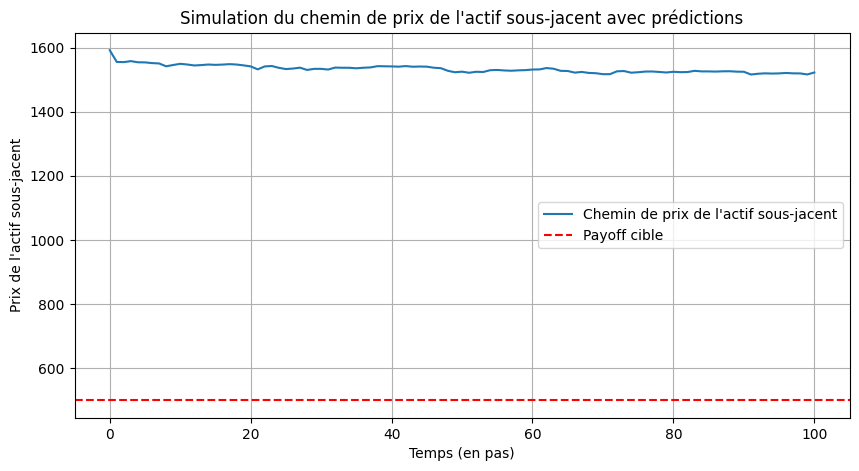

Valeur cible du payoff de l'option digitale : 500


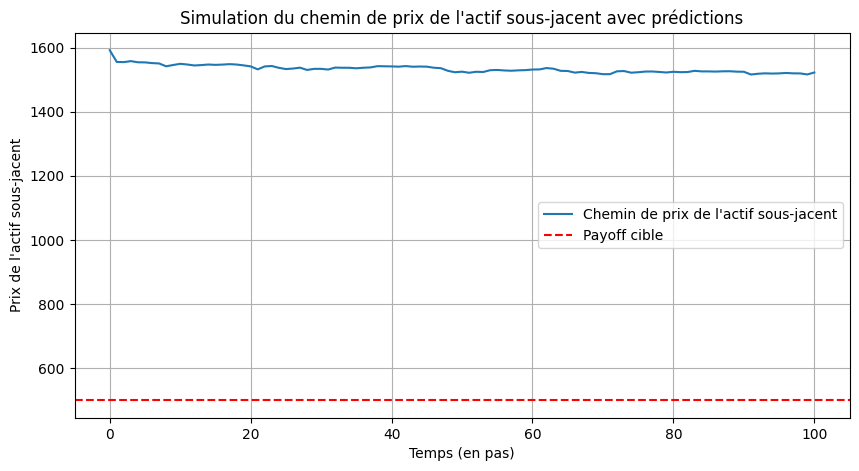

Valeur cible du payoff de l'option digitale : 500
Payoff final du portefeuille de réplication : 351.0504626156535


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_delta_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Fonction de coût avec gestion du risque (variance)
def cost_function_with_risk(n_calls, S0, strikes, T, r, sigma, target_payoff, n_steps, predictions, lambda_risk=0.1):
    dt = T / n_steps
    S_path = np.zeros(n_steps + 1)
    S_path[0] = S0

    # Utiliser les prédictions de prix au lieu de simuler
    for t in range(1, n_steps + 1):
        S_path[t] = predictions[t]

    calls_weights = np.zeros((n_steps + 1, n_calls))
    portfolio_value = np.zeros(n_steps + 1)

    for t in range(n_steps):
        T_remaining = T - (t * dt)
        call_prices = [black_scholes_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]
        deltas_calls = [black_scholes_delta_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]

        current_portfolio_value = sum(calls_weights[t, i] * call_prices[i] for i in range(n_calls))

        needed_adjustment = target_payoff - current_portfolio_value

        # Ajuster les poids des calls
        for i in range(n_calls):
            calls_weights[t + 1, i] = calls_weights[t, i] + (needed_adjustment * dt) * deltas_calls[i]

        portfolio_value[t + 1] = sum(calls_weights[t + 1, i] * call_prices[i] for i in range(n_calls))

    # Calcul de la variance du portefeuille
    mean_portfolio_value = np.mean(portfolio_value)
    portfolio_variance = np.var(portfolio_value)

    # Coût total : écart par rapport au payoff cible + risque (variance)
    cost = abs(portfolio_value[-1] - target_payoff) + lambda_risk * portfolio_variance
    return cost, strikes


# Paramètres du modèle
S0 = valid_df['Predictions'].iloc[-1]  # Prix initial de l'actif sous-jacent prédit par le modèle LSTM
T = 1  # Temps à maturité
r = 0.05  # Taux d'intérêt sans risque
sigma = 0.3  # Volatilité
n_steps = 100  # Nombre de pas de temps

# Définir le marché des options (seulement des calls)
strikes = np.random.uniform(1000, 1200, 30)

# Utiliser les prédictions pour l'intégration dans le marché des options
predictions = valid_df['Predictions'].values  # Récupérer les prédictions du modèle LSTM

# Valeur fixe de payoff de l'option digitale
target_payoff = 500 # Valeur connue pour le payoff de l'option digitale

# Tester différentes combinaisons d'options vanilles
optimal_n_calls = None
min_cost = float('inf')
optimal_strikes = None  # Pour stocker les strikes optimaux
selected_options_info = []  # Pour stocker les informations des options sélectionnées

# Tester toutes les combinaisons possibles de calls
for n_calls in range(1, len(strikes) + 1):
    cost, strikes = cost_function_with_risk(n_calls, S0, strikes, T, r, sigma, target_payoff, n_steps, predictions)
    if cost < min_cost:
        min_cost = cost
        optimal_n_calls = n_calls
        optimal_strikes = strikes  # Store the optimal strikes

# Résumé des résultats
optimal_strikes = strikes[:optimal_n_calls]
selected_options_info = [{'type': 'call', 'strike': K, 'expiration': T} for K in optimal_strikes]

print(f"Nombre optimal d'options d'achat : {optimal_n_calls}")
print(f"Strikes des options optimaux : {optimal_strikes}")
print("Informations sur les options sélectionnées :")
for option in selected_options_info:
    print(f"Type: {option['type']}, Strike: {option['strike']}, Échéance: {option['expiration']} ans")

# Visualisation avec le nombre optimal d'options
dt = T / n_steps
S_path = np.zeros(n_steps + 1)
S_path[0] = S0

# Utiliser les prédictions pour ajuster la simulation
for t in range(1, n_steps + 1):
    S_path[t] = predictions[t]

calls_weights = np.zeros((n_steps + 1, optimal_n_calls))
portfolio_value = np.zeros(n_steps + 1)

for t in range(n_steps):
    T_remaining = T - (t * dt)
    call_prices = [black_scholes_call(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[:optimal_n_calls]]
    deltas_calls = [black_scholes_delta_call(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[:optimal_n_calls]]

    current_portfolio_value = sum(calls_weights[t, i] * call_prices[i] for i in range(optimal_n_calls))

    needed_adjustment = target_payoff - current_portfolio_value

    portfolio_value[t + 1] = sum(calls_weights[t + 1, i] * call_prices[i] for i in range(optimal_n_calls))

# Visualisation des résultats
plt.figure(figsize=(10, 5))
plt.plot(S_path, label='Chemin de prix de l\'actif sous-jacent')
plt.title('Simulation du chemin de prix de l\'actif sous-jacent avec prédictions')
plt.xlabel('Temps (en pas)')
plt.ylabel('Prix de l\'actif sous-jacent')
plt.axhline(y=target_payoff, color='r', linestyle='--', label='Payoff cible')
plt.legend()
plt.grid()
plt.show()

print(f"Valeur cible du payoff de l'option digitale : {target_payoff}")
final_price = S_path[-1]  # Prix de l'actif sous-jacent à la fin de la simulation

# Calculer le payoff des options d'achat
payoff_calls = sum(max(0, final_price - K) for K in optimal_strikes[:optimal_n_calls])

# Le payoff total du portefeuille de réplication
total_payoff = payoff_calls

# Visualisation des résultats
plt.figure(figsize=(10, 5))
plt.plot(S_path, label='Chemin de prix de l\'actif sous-jacent')
plt.title('Simulation du chemin de prix de l\'actif sous-jacent avec prédictions')
plt.xlabel('Temps (en pas)')
plt.ylabel('Prix de l\'actif sous-jacent')
plt.axhline(y=target_payoff, color='r', linestyle='--', label='Payoff cible')
plt.legend()
plt.grid()
plt.show()

print(f"Valeur cible du payoff de l'option digitale : {target_payoff}")
print(f"Payoff final du portefeuille de réplication : {total_payoff}")


#analyse des greeks

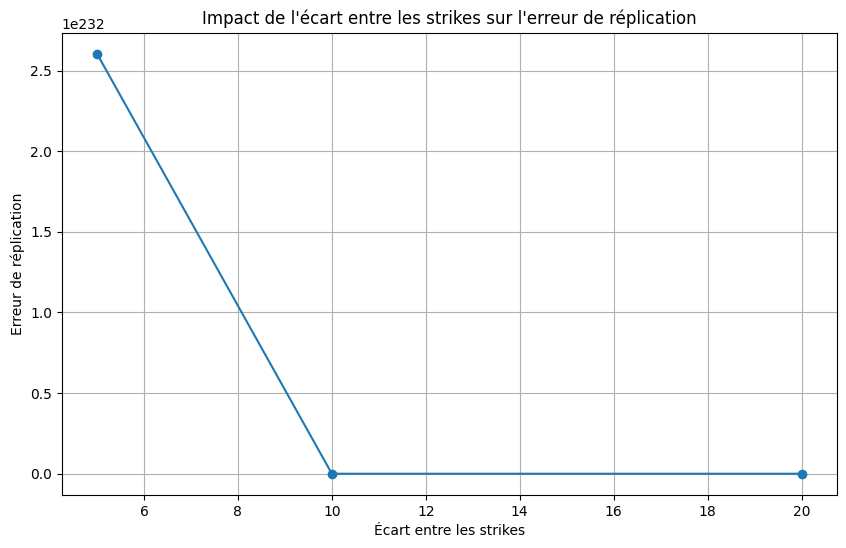

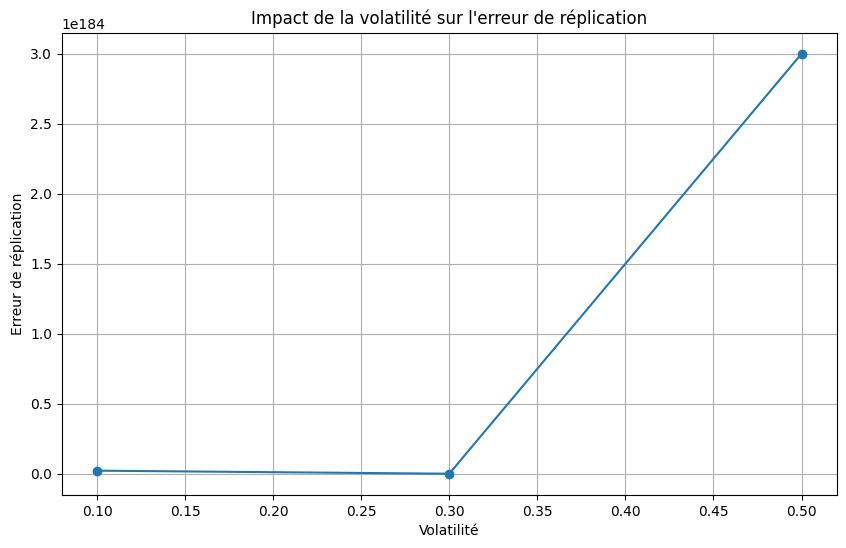

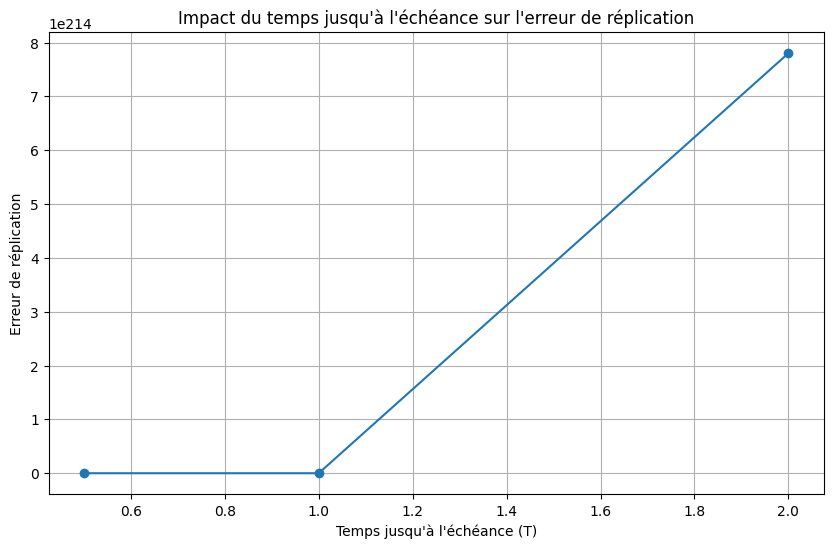

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Fonction de coût pour évaluer la performance du portefeuille avec calls uniquement
def cost_function(n_calls, S0, strikes, T, r, sigma, target_payoff, n_steps, predictions):
    dt = T / n_steps
    S_path = np.zeros(n_steps + 1)
    S_path[0] = S0

    # Utiliser les prédictions de prix au lieu de simuler
    for t in range(1, n_steps + 1):
        S_path[t] = predictions[t]

    calls_weights = np.zeros((n_steps + 1, n_calls))
    portfolio_value = np.zeros(n_steps + 1)

    for t in range(n_steps):
        T_remaining = T - (t * dt)
        call_prices = [black_scholes_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]
        deltas_calls = [black_scholes_delta_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]

        current_portfolio_value = sum(calls_weights[t, i] * call_prices[i] for i in range(n_calls))
        needed_adjustment = target_payoff - current_portfolio_value

        # Ajuster les poids des calls
        for i in range(n_calls):
            calls_weights[t + 1, i] = calls_weights[t, i] + (needed_adjustment * dt) * deltas_calls[i]

        portfolio_value[t + 1] = sum(calls_weights[t + 1, i] * call_prices[i] for i in range(n_calls))

    return abs(portfolio_value[-1] - target_payoff), strikes  # Retourner l'écart absolu et les strikes

# Fonction pour analyser l'erreur de réplication en fonction des paramètres
def analyze_replication_error(S0, T, r, sigma, target_payoff, n_steps, predictions):
    errors_strike_diff = []
    errors_volatility = []
    errors_maturity = []

    # Test de l'impact de l'écart entre les strikes
    for strike_diff in [5, 10, 20]:
        strikes = np.arange(80, 150, strike_diff)
        n_calls = len(strikes)
        cost, strikes = cost_function(n_calls, S0, strikes, T, r, sigma, target_payoff, n_steps, predictions)
        errors_strike_diff.append((strike_diff, cost))

    # Test de l'impact de la volatilité
    for vol in [0.1, 0.3, 0.5]:
        strikes = np.random.uniform(1000, 2000, 30)
        n_calls = len(strikes)
        cost, strikes = cost_function(n_calls, S0, strikes, T, r, vol, target_payoff, n_steps, predictions)
        errors_volatility.append((vol, cost))

    # Test de l'impact du temps jusqu'à l'échéance
    for maturity in [0.5, 1, 2]:
        strikes = np.random.uniform(1000, 2000, 30)
        n_calls = len(strikes)
        cost, strikes = cost_function(n_calls, S0, strikes, maturity, r, sigma, target_payoff, n_steps, predictions)
        errors_maturity.append((maturity, cost))

    return errors_strike_diff, errors_volatility, errors_maturity

# Paramètres du modèle
S0 = valid_df['Predictions'].iloc[-1]  # Prix initial de l'actif sous-jacent prédit par le modèle LSTM
T = 1  # Temps à maturité
r = 0.05  # Taux d'intérêt sans risque
sigma = 0.3  # Volatilité
n_steps = 100  # Nombre de pas de temps

# Valeur fixe de payoff de l'option digitale
target_payoff = 500 # Valeur connue pour le payoff de l'option digitale

# Utiliser les prédictions pour l'intégration dans le marché des options
predictions = valid_df['Predictions'].values  # Récupérer les prédictions du modèle LSTM

# Analyser l'erreur de réplication pour différentes configurations
errors_strike_diff, errors_volatility, errors_maturity = analyze_replication_error(S0, T, r, sigma, target_payoff, n_steps, predictions)

# Visualisation de l'impact de l'écart entre les strikes
plt.figure(figsize=(10, 6))
strike_diffs, strike_errors = zip(*errors_strike_diff)
plt.plot(strike_diffs, strike_errors, label="Erreur de réplication", marker='o')
plt.xlabel('Écart entre les strikes')
plt.ylabel('Erreur de réplication')
plt.title("Impact de l'écart entre les strikes sur l'erreur de réplication")
plt.grid(True)
plt.show()

# Visualisation de l'impact de la volatilité sur l'erreur de réplication
plt.figure(figsize=(10, 6))
volatilities, volatility_errors = zip(*errors_volatility)
plt.plot(volatilities, volatility_errors, label="Erreur de réplication", marker='o')
plt.xlabel('Volatilité')
plt.ylabel('Erreur de réplication')
plt.title("Impact de la volatilité sur l'erreur de réplication")
plt.grid(True)
plt.show()

# Visualisation de l'impact du temps jusqu'à l'échéance sur l'erreur de réplication
plt.figure(figsize=(10, 6))
maturities, maturity_errors = zip(*errors_maturity)
plt.plot(maturities, maturity_errors, label="Erreur de réplication", marker='o')
plt.xlabel('Temps jusqu\'à l\'échéance (T)')
plt.ylabel('Erreur de réplication')
plt.title("Impact du temps jusqu'à l'échéance sur l'erreur de réplication")
plt.grid(True)
plt.show()


l'impact de la valeur cible

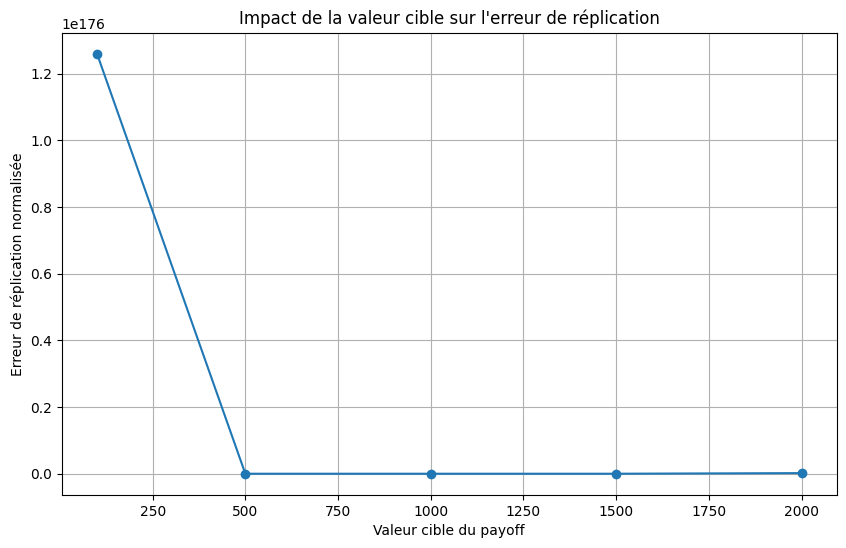

jjjjjj


Nombre optimal d'options d'achat : 1
Strikes des options optimaux : [80.]
Informations sur les options sélectionnées :
Type: call, Strike: 80.0, Échéance: 1 ans
Payoff final atteint par le portefeuille de réplication : 1770.67
Écart avec le payoff cible : 270.67


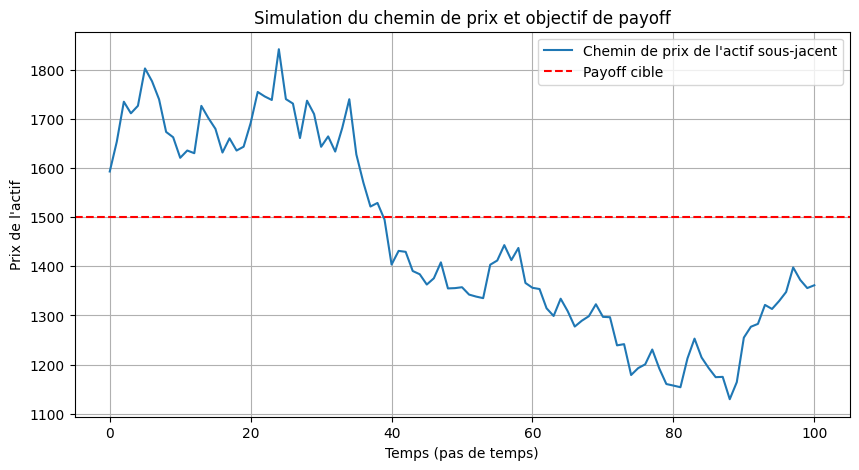

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes pour le prix d'un call
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Black-Scholes pour le delta d'un call
def black_scholes_delta_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Fonction de coût pour évaluer la performance du portefeuille
def cost_function(n_calls, S0, strikes, T, r, sigma, target_payoff, n_steps):
    dt = T / n_steps
    portfolio_value = np.zeros(n_steps + 1)
    portfolio_value[0] = 0  # Initialisation du portefeuille

    # Simulation du chemin de prix
    S_path = np.zeros(n_steps + 1)
    S_path[0] = S0
    for t in range(1, n_steps + 1):
        Z = np.random.normal()
        S_path[t] = S_path[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

    # Calcul des prix des calls et du portefeuille
    for t in range(n_steps):
        T_remaining = T - (t * dt)
        call_prices = [black_scholes_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]
        portfolio_value[t + 1] = sum(call_prices)

    # Coût basé sur l'écart absolu avec le payoff cible
    return abs(portfolio_value[-1] - target_payoff), portfolio_value[-1]

# Paramètres
S0 = valid_df['Predictions'].iloc[-1]  # Prix initial de l'actif sous-jacent
T = 1  # Temps à maturité (en années)
r = 0.05  # Taux sans risque
sigma = 0.3  # Volatilité
n_steps = 100  # Nombre de pas de temps
strikes = np.linspace(80, 150, 30)  # Ensemble des strikes disponibles
target_payoff = 1500  # Payoff cible de l'option digitale

# Recherche du nombre optimal d'options
optimal_n_calls = None
min_cost = float('inf')
optimal_payoff = None

for n_calls in range(1, len(strikes) + 1):
    cost, payoff = cost_function(n_calls, S0, strikes, T, r, sigma, target_payoff, n_steps)
    if cost < min_cost:
        min_cost = cost
        optimal_n_calls = n_calls
        optimal_payoff = payoff

# Résumé des résultats
optimal_strikes = strikes[:optimal_n_calls]
selected_options_info = [{'type': 'call', 'strike': K, 'expiration': T} for K in optimal_strikes]

print(f"Nombre optimal d'options d'achat : {optimal_n_calls}")
print(f"Strikes des options optimaux : {optimal_strikes}")
print("Informations sur les options sélectionnées :")
for option in selected_options_info:
    print(f"Type: {option['type']}, Strike: {option['strike']}, Échéance: {option['expiration']} ans")
print(f"Payoff final atteint par le portefeuille de réplication : {optimal_payoff:.2f}")
print(f"Écart avec le payoff cible : {min_cost:.2f}")

# Simulation du chemin de prix pour visualisation
dt = T / n_steps
S_path = np.zeros(n_steps + 1)
S_path[0] = S0

for t in range(1, n_steps + 1):
    Z = np.random.normal()
    S_path[t] = S_path[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

# Visualisation
plt.figure(figsize=(10, 5))
plt.plot(S_path, label='Chemin de prix de l\'actif sous-jacent')
plt.axhline(y=target_payoff, color='r', linestyle='--', label='Payoff cible')
plt.title('Simulation du chemin de prix et objectif de payoff')
plt.xlabel('Temps (pas de temps)')
plt.ylabel('Prix de l\'actif')
plt.legend()
plt.grid()
plt.show()


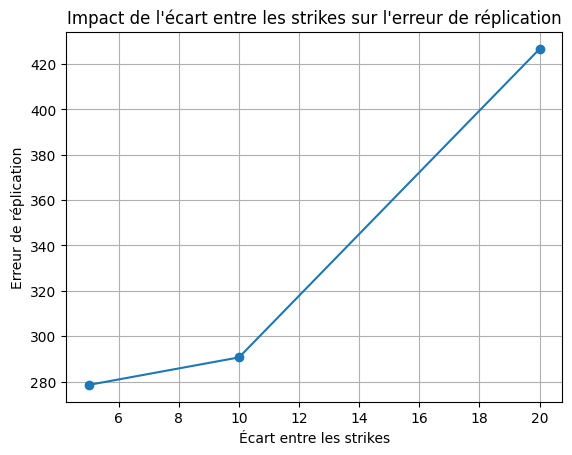

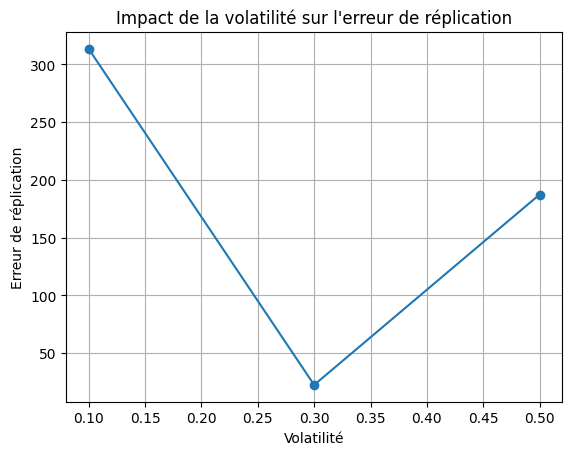

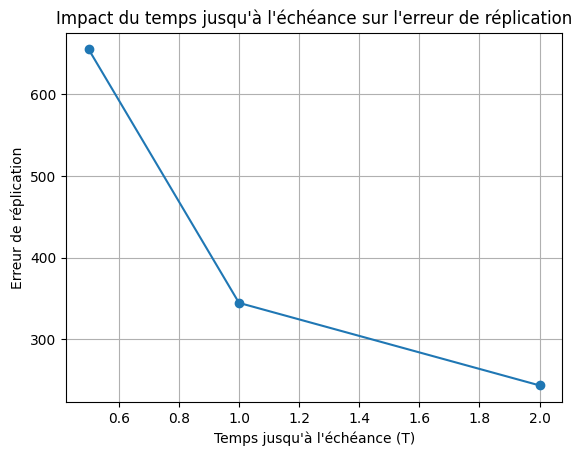

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Définir la fonction de Black-Scholes pour les options d'achat
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Calculer la sensibilité Delta pour les calls
def black_scholes_delta_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Fonction pour simuler le portefeuille de réplication
def replicate_portfolio(S0, strikes, T, r, sigma, target_payoff, n_steps, n_calls):
    dt = T / n_steps
    S_path = np.zeros(n_steps + 1)
    S_path[0] = S0
    calls_weights = np.zeros((n_steps + 1, n_calls))
    portfolio_value = np.zeros(n_steps + 1)

    for t in range(1, n_steps + 1):
        Z = np.random.normal()
        S_path[t] = S_path[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

    for t in range(n_steps):
        T_remaining = T - (t * dt)
        call_prices = [black_scholes_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]
        deltas_calls = [black_scholes_delta_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]
        current_portfolio_value = sum(calls_weights[t, i] * call_prices[i] for i in range(n_calls))
        needed_adjustment = target_payoff - current_portfolio_value

        for i in range(n_calls):
            calls_weights[t + 1, i] = calls_weights[t, i] + (needed_adjustment * dt) * deltas_calls[i]

        portfolio_value[t + 1] = sum(calls_weights[t + 1, i] * call_prices[i] for i in range(n_calls))

    return S_path, portfolio_value, calls_weights

# Calculer le payoff final du portefeuille et l'erreur de réplication
def calculate_replication_error(S_path, portfolio_value, target_payoff):
    final_price = S_path[-1]
    payoff_calls = sum(max(0, final_price - K) for K in optimal_strikes[:optimal_n_calls])
    total_payoff = payoff_calls
    error = abs(total_payoff - target_payoff)
    return error, total_payoff, payoff_calls

# Paramètres de simulation
S0 = valid_df['Predictions'].iloc[-1]  # Prix initial de l'actif sous-jacent
T = 1  # Temps à maturité
r = 0.05  # Taux d'intérêt sans risque
sigma = 0.3  # Volatilité
n_steps = 100  # Nombre de pas de temps
target_payoff = 2000  # Payoff de l'option digitale

# Tester l'erreur de réplication avec différentes valeurs d'écart entre les strikes, de volatilité et de temps jusqu'à l'échéance
errors = []
for strike_diff in [5, 10, 20]:  # Différence entre les strikes
    strikes = np.arange(80, 150, strike_diff)
    n_calls = len(strikes)
    S_path, portfolio_value, calls_weights = replicate_portfolio(S0, strikes, T, r, sigma, target_payoff, n_steps, n_calls)
    error, total_payoff, payoff_calls = calculate_replication_error(S_path, portfolio_value, target_payoff)
    errors.append((strike_diff, error, total_payoff, payoff_calls))

# Visualiser l'impact de l'écart entre les strikes
strike_diffs, errors_vals, total_payoffs, payoff_calls = zip(*errors)
plt.plot(strike_diffs, errors_vals, label="Erreur de réplication", marker='o')
plt.xlabel('Écart entre les strikes')
plt.ylabel('Erreur de réplication')
plt.title("Impact de l'écart entre les strikes sur l'erreur de réplication")
plt.grid(True)
plt.show()

# Analyser l'erreur de réplication pour différentes volatilités
volatilities = [0.1, 0.3, 0.5]
errors_volatility = []
for vol in volatilities:
    strikes = np.arange(80, 150, 10)
    n_calls = len(strikes)
    S_path, portfolio_value, calls_weights = replicate_portfolio(S0, strikes, T, r, vol, target_payoff, n_steps, n_calls)
    error, total_payoff, payoff_calls = calculate_replication_error(S_path, portfolio_value, target_payoff)
    errors_volatility.append((vol, error))

# Visualiser l'impact de la volatilité sur l'erreur de réplication
vol_values, volatility_errors = zip(*errors_volatility)
plt.plot(vol_values, volatility_errors, label="Erreur de réplication", marker='o')
plt.xlabel('Volatilité')
plt.ylabel('Erreur de réplication')
plt.title("Impact de la volatilité sur l'erreur de réplication")
plt.grid(True)
plt.show()

# Analyser l'erreur de réplication pour différents temps jusqu'à l'échéance
times_to_maturity = [0.5, 1, 2]
errors_maturity = []
for T_maturity in times_to_maturity:
    strikes = np.arange(80, 150, 10)
    n_calls = len(strikes)
    S_path, portfolio_value, calls_weights = replicate_portfolio(S0, strikes, T_maturity, r, sigma, target_payoff, n_steps, n_calls)
    error, total_payoff, payoff_calls = calculate_replication_error(S_path, portfolio_value, target_payoff)
    errors_maturity.append((T_maturity, error))

# Visualiser l'impact du temps jusqu'à l'échéance sur l'erreur de réplication
maturity_values, maturity_errors = zip(*errors_maturity)
plt.plot(maturity_values, maturity_errors, label="Erreur de réplication", marker='o')
plt.xlabel('Temps jusqu\'à l\'échéance (T)')
plt.ylabel('Erreur de réplication')
plt.title("Impact du temps jusqu'à l'échéance sur l'erreur de réplication")
plt.grid(True)
plt.show()
